# Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch_geometric.data import Data, Batch, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, NNConv, MessagePassing, GATv2Conv, TransformerConv
from torch_geometric.utils import to_networkx

In [2]:
import pandas as pd
import numpy as np
import itertools
import json
import math
import random
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from geopy.distance import geodesic
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
from pyproj import Transformer


In [3]:
import importlib
import PyTorch_GNN.utils as utils

In [4]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.autograd.set_detect_anomaly(True)

# Load data

In [5]:
path = 'almrrc2021/almrrc2021-data-training/model_build_inputs/'

In [6]:
with open(path + 'route_data.json') as f:
  routes = json.load(f)

In [7]:
with open(path + 'actual_sequences.json') as f:
  actual = json.load(f)

In [8]:
with open(path + 'package_data.json') as f:
  package_json = json.load(f)

In [9]:
with open(path + 'travel_times.json') as f:
  times = json.load(f)

In [15]:
# actual

In [12]:
# rows = []

# for route_id, route_info in routes.items():
#   general_info = {
#     "route_id": route_id,
#     "station_code": route_info["station_code"],
#     "date": route_info["date_YYYY_MM_DD"],
#     "departure_time_utc": route_info["departure_time_utc"],
#     "executor_capacity_cm3": route_info["executor_capacity_cm3"],
#     "route_score": route_info["route_score"],
#   }

#   stops = route_info.get("stops", {})
#   for stop_id, stop_info in stops.items():
#     row = {
#       **general_info,
#       "stop_id": stop_id,
#       "lat": stop_info["lat"],
#       "lng": stop_info["lng"],
#       "type": stop_info["type"],
#       "zone_id": stop_info["zone_id"],
#     }
#     rows.append(row)

# df = pd.DataFrame(rows)

# df = df[df["route_score"] != "Low"]

In [13]:
# routes_dict = {}

# for route, data in df.groupby("route_id"):
#   routes_dict[route] = {
#       "lat": data["lat"].mean().item(),
#       "lng": data["lng"].mean().item()
#   }


# routes_df = pd.DataFrame(routes_dict).T

# coords = routes_df[["lat", "lng"]].to_numpy()

# db = DBSCAN(eps=0.01, min_samples=5, metric='haversine').fit(np.radians(coords))
# routes_df["cluster"] = db.labels_
# routes_df = routes_df.reset_index().rename(columns={"index": "route_id"})

# df = df.merge(routes_df[["route_id", "cluster"]], on="route_id", how="left")
# df = df[df["cluster"] == 0]

In [14]:
# actual_routes_list = []

# for route_id in df["route_id"].unique():
#     actual_df = pd.DataFrame(actual[route_id])
#     actual_df["route_id"] = route_id
#     actual_df = actual_df.reset_index().rename(columns={"index": "stop_id", "actual": "order"})
#     actual_df["is_start"] = actual_df["order"].apply(lambda x: True if x == 0 else False)
#     actual_routes_list.append(actual_df[["route_id", "stop_id", "order", "is_start"]])

# actual_routes = pd.concat(actual_routes_list, ignore_index=True)
# df = df.merge(actual_routes, on=["route_id", "stop_id"], how="left")

In [15]:
# df.loc[pd.isna(df["zone_id"]) & (df["order"] == 0), "zone_id"] = "Depot"
# df["zone_id"] = df["zone_id"].fillna("Unknown")

In [16]:
# package_df = pd.DataFrame(package_json)
# package_df = package_df.reset_index().rename(columns={"index": "stop_id"})
# rows = []
# for route in df["route_id"].unique():
#     route_packages = package_df[["stop_id", route]].dropna()
#     route_packages = route_packages.set_index("stop_id")
#     for stop, package in route_packages.iterrows():
#         p = package.values[0]
#         package_info = list(p.values())
#         if len(package_info) > 0:
#             rows.append({
#                 "route_id": route,
#                 "stop_id": stop,
#                 "planned_time": package_info[0]["planned_service_time_seconds"],
#             })

# pdf = pd.DataFrame(rows)

# df = df.merge(pdf, on=["route_id", "stop_id"], how="left")

In [17]:
# df["planned_time"] = df["planned_time"].fillna(0.0)

In [18]:
# grouped = df.groupby(by="route_id")

In [19]:
# df.to_parquet("df_la.parquet")

In [10]:
df = pd.read_parquet("df_la.parquet")
grouped = df.groupby(by="route_id")

# Create dataset

In [11]:
def calculate_time_old(id_route, stop_list):
    total_time = 0
    for stop in stop_list[:-1]:
        total_time += times[id_route][stop][stop_list[stop_list.index(stop) + 1]]
    return total_time

def calculate_time(id_route, stop_list):
    total_time = 0
    for src, tgt in zip(stop_list[:-1], stop_list[1:]):
        total_time += times[id_route][src][tgt]
    return total_time

In [19]:
importlib.reload(utils)

stops_idx = {}
avoid_creating = False

file = "PyTorch_GNN/graph_lists/graph_list_improved.pt"

if os.path.exists(file):
        graph_list = torch.load(file, weights_only=False)
        avoid_creating = True
        print("Graphs loaded from file")
else:
    graph_list = []

# graph_list = []

all_zones = df["zone_id"].unique().tolist()

zone_encoder = LabelEncoder()
zone_embedding = nn.Embedding(num_embeddings=len(all_zones), embedding_dim=32)

zone_encoder = LabelEncoder()
zone_encoder.fit(all_zones)

zone_coords = utils.calculate_zone_coords(df)
zone_embedding = utils.init_zone_embeddings(zone_encoder, zone_coords)

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)


for route_id, route in tqdm(grouped, desc="Processing routes"):
    stops_idx[route_id] = {i : stop for i, stop in enumerate(route.stop_id)}
    if avoid_creating:
        continue
    
    idx_stops = {stop: i for i, stop in enumerate(route.stop_id)}

    centroid_lat, centroid_lng = utils.calculate_route_centroid(route)
    centroid_x, centroid_y = transformer.transform(centroid_lng, centroid_lat)
    centroid = torch.tensor([centroid_x, centroid_y], dtype=torch.float)

    coords = torch.tensor(route[["lat", "lng"]].values, dtype=torch.float)
    coords_zs = utils.zscore(coords)
    positional_encodings = utils.positional_encoding(coords_zs)
    pe_tensor = torch.tensor(positional_encodings, dtype=torch.float)

    zone_ids = zone_encoder.transform(route["zone_id"])
    zone_ids = torch.tensor(zone_ids, dtype=torch.long)
    with torch.no_grad():
        zone_vectors = zone_embedding(zone_ids)

    lats = coords[:, 0].numpy()
    lngs = coords[:, 1].numpy()

    xs, ys = transformer.transform(lngs, lats)
    xy_coords = torch.tensor(list(zip(xs, ys)), dtype=torch.float)

    dist_to_centroid = torch.norm(xy_coords - centroid, dim=1).unsqueeze(1)

    # planned_time = torch.tensor(route["planned_time"].values, dtype=torch.float).unsqueeze(1)
    # time_zs = utils.zscore(planned_time)

    x = torch.cat([coords, pe_tensor, zone_vectors, dist_to_centroid], dim=1)

    edges = []
    edge_weights = []

    coords_dict = route.set_index("stop_id")[["lat", "lng"]].to_dict("index")

    projected_coords = {
        stop_id: transformer.transform(stop["lng"], stop["lat"])
        for stop_id, stop in coords_dict.items()
    }

    dist_extremes_list = []
    cosine_sims_list = []
    sims = []
    for i, stop in enumerate(route.stop_id):
        d = times[route_id][stop]
        sorted_d = dict(sorted(d.items(), key=lambda item: item[1])) # Sort stops by distance
        top_d = dict(list(sorted_d.items())[1:51]) # Maintain the N closest stops, excluding the autoreference
        min_dist = min(top_d.values())
        max_dist = max(top_d.values())
        dist_extremes_list.append([min_dist, max_dist])
        for stop2 in top_d.keys():
            if stop != stop2:
                j_idx = idx_stops[stop2]
                sim = F.cosine_similarity(x[i], x[j_idx], dim=0)
                sims.append(sim.item())
                edges.append([i, idx_stops[stop2]])
                x1, y1 = projected_coords[stop]
                x2, y2 = projected_coords[stop2]
                dist = np.hypot(x2 - x1, y2 - y1)  # Distance between stops              
                edge_weights.append([top_d[stop2], dist])
        mean_sim = np.mean(sims)
        std_sim = np.std(sims)
        cosine_sims_list.append([mean_sim, std_sim])


    dist_extremes_tensor = torch.tensor(dist_extremes_list, dtype=torch.float)
    x = torch.cat([x, dist_extremes_tensor], dim=1)

    cosine_sims_tensor = torch.tensor(cosine_sims_list, dtype=torch.float)
    x = torch.cat([x, cosine_sims_tensor], dim=1)

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_weights, dtype=torch.float)

    start = route[route["order"] == 0]["stop_id"].values[0]
    start = idx_stops[start]

    graph_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, route_id=route_id, start_node=start))


Graphs loaded from file


Processing routes: 100%|██████████| 2831/2831 [00:00<00:00, 32952.60it/s]


In [18]:
graph_list[0].x.shape

torch.Size([119, 40])

tensor(0.4496) tensor(0.4220)
Unique similarity values: tensor([0.0000, 0.1000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000, 1.0000])


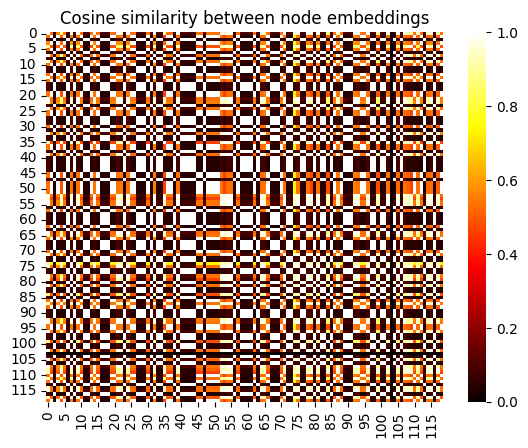

In [27]:
import PyTorch_GNN.GNNEncoder
importlib.reload(PyTorch_GNN.GNNEncoder)

gnn = PyTorch_GNN.GNNEncoder.GNN(node_features=29, edge_features=2, hidden_channels=128, heads=4)

gnn.eval()

with torch.no_grad():
    data = graph_list[0]
    node_embeddings = gnn(data.x, data.edge_index, data.edge_attr, data.batch)
    cos_sim_matrix = torch.nn.functional.cosine_similarity(
        node_embeddings.unsqueeze(1),
        node_embeddings.unsqueeze(0),
        dim=-1
    )

print(cos_sim_matrix.mean(), cos_sim_matrix.std())

cos_similarities = torch.cosine_similarity(node_embeddings.unsqueeze(1), node_embeddings.unsqueeze(0), dim=2)
unique_vals = torch.unique(cos_similarities.round(decimals=1))
print(f"Unique similarity values: {unique_vals}")

sns.heatmap(cos_sim_matrix.cpu().numpy(), cmap="hot")
plt.title("Cosine similarity between node embeddings")
plt.show()

In [ ]:
sims = []

for graph in graph_list:
    node_embeddings = gnn(data.x, data.edge_index, data.edge_attr, data.batch)
    sim = torch.cosine_similarity(node_embeddings.unsqueeze(1), node_embeddings.unsqueeze(0), dim=2)
    mean_sim = sim.mean()
    sims.append(mean_sim)

np.mean(sims)

In [10]:
if not os.path.exists("graph_list.pt"):
    torch.save(graph_list, "graph_list.pt")

total_len = len(graph_list)
val_ratio = 0.2
val_len = int(total_len * val_ratio)
train_len = total_len - val_len

train_dataset, val_dataset = random_split(graph_list, [train_len, val_len])

In [11]:
val_loader_test = DataLoader(val_dataset, batch_size=1, shuffle=False, pin_memory=True, num_workers=4)
tour_lengths = []
for route in val_loader_test:
    route_id = route.route_id[0]
    actual_route = df[df["route_id"] == route_id].sort_values(by="order")["stop_id"].tolist()
    actual_time = calculate_time(route_id, actual_route)
    tour_lengths.append(actual_time)

mean_tour_length = np.mean(tour_lengths)
print(f"Mean tour length: {mean_tour_length:.2f} seconds")


Mean tour length: 9913.23 seconds


In [ ]:
# G = to_networkx(graph_list[0])

# plt.figure(figsize=(8, 6))
# nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500)
# plt.title("Visualización del Grafo")
# plt.show()

In [58]:
# l = [stops_idx[graph_list[56].route_id][s] for s in graph_list[0].y.tolist()]
# t1 = calculate_time(graph_list[56].route_id, l)
# t2 = calculate_time_old(graph_list[56].route_id, l)

# print(f"Calculated time: {t1}, Old time: {t2}")

# Model

In [38]:
class GNN(nn.Module):
    def __init__(self, node_features, edge_features, hidden_channels, heads, dropout=0.2):
        super().__init__()
        self.dropout = dropout

        self.conv1 = GATv2Conv(node_features, hidden_channels//2, heads=heads, dropout=dropout, edge_dim=edge_features, add_self_loops=False)
        self.conv2 = GATv2Conv((hidden_channels//2) * heads, hidden_channels, heads=heads//2, dropout=dropout, edge_dim=edge_features, add_self_loops=False)
        self.conv3 = GATv2Conv(hidden_channels * (heads//2), hidden_channels, heads=1, dropout=dropout, edge_dim=edge_features, add_self_loops=False, concat=False)

        self.norm1 = nn.LayerNorm((hidden_channels//2) * heads)
        self.norm2 = nn.LayerNorm(hidden_channels * (heads//2))
        self.norm3 = nn.LayerNorm(hidden_channels)


    def forward(self, x, edge_index, edge_attr, batch):
        x1 = self.conv1(x, edge_index, edge_attr=edge_attr)
        x1 = self.norm1(x1)
        x1 = F.elu(x1)
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        x2 = self.conv2(x1, edge_index, edge_attr=edge_attr)
        x2 = self.norm2(x2)
        x2 = F.elu(x2 + x1)
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        x3 = self.conv3(x2, edge_index, edge_attr=edge_attr)
        x3 = self.norm3(x3)

        # if batch is not None:
        #     graph_embed = global_mean_pool(x3, batch)
        #     return x3, graph_embed

        return x3

In [22]:
class PointerDecoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.query_proj = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        self.key_proj = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        self.rnn = nn.GRU(embed_dim, embed_dim)
        self.v = nn.Parameter(torch.randn(embed_dim))

    def forward(self, node_embeddings, start_nodes, batch_idx):
        device = node_embeddings.device
        batch_size = start_nodes.size(0)
        total_nodes = node_embeddings.size(0)
        hidden_dim = node_embeddings.size(1)

        mask = torch.ones(total_nodes, dtype=torch.bool, device=device)
        hidden = torch.zeros(1, batch_size, hidden_dim, device=node_embeddings.device)

        current = start_nodes.clone()

        tours = [[] for _ in range(batch_size)]
        log_probs = [[] for _ in range(batch_size)]

        for _ in range(250):
            active_graphs = []
            for i in range(batch_size):
                node_indices = (batch_idx == i).nonzero(as_tuple=False).squeeze()
                if len(tours[i]) >= len(node_indices):
                    continue
                
                tours[i].append(current[i].item())
                mask[current[i]] = False
                active_graphs.append(i)

            if not active_graphs:
                break

            active_graph_tensor = torch.tensor(active_graphs, device=device)

            node_embed = node_embeddings[current[active_graph_tensor]].unsqueeze(0)
            _, hidden[:, active_graph_tensor] = self.rnn(node_embed, hidden[:, active_graph_tensor])

            query = self.query_proj(hidden[0, active_graph_tensor])
            keys = self.key_proj(node_embeddings)

            query = F.normalize(query, dim=-1)
            keys = F.normalize(keys, dim=-1)

            scores = torch.matmul(torch.tanh(keys + query.unsqueeze(1)), self.v).squeeze(-1)

            for idx_i, batch_id in enumerate(active_graphs):
                node_ids = (batch_idx == batch_id).nonzero(as_tuple=False).squeeze()
                local_mask = torch.zeros(total_nodes, dtype=torch.bool, device=device)
                local_mask[node_ids] = True
                local_mask = local_mask & mask
                scores[idx_i][~local_mask] = -1e9

            probs = F.softmax(scores, dim=1)
            log_prob = torch.log(probs + 1e-10)

            if self.training:
                next_nodes = torch.multinomial(probs, 1).squeeze(1)
            else:
                next_nodes = torch.argmax(probs, dim=1)

            for idx_i, batch_id in enumerate(active_graphs):
                log_probs[batch_id].append(log_prob[idx_i, next_nodes[idx_i]])
                current[batch_id] = next_nodes[idx_i]


        final_tours = [torch.tensor(t, device=device) for t in tours]
        final_log_probs = [torch.stack(lp) for lp in log_probs]

        return final_tours, final_log_probs

In [23]:
def reinforce_loss(tour_length, log_probs, baseline=None):
    if baseline is None:
        reward = -tour_length
    else:
        reward = baseline - tour_length

    # reward /= 1000000.0

    if log_probs.ndim > 1:
        log_probs = log_probs.sum(dim=1)
    
    loss = -torch.mean(log_probs * reward.detach())
    return loss

In [24]:
def evaluate(encoder, decoder, loader, device):
    encoder.eval()
    decoder.eval()

    tour_lengths = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            node_embeddings = encoder(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            batch_size = batch.num_graphs

            start_nodes = []
            for i in range(batch_size):
                node_indices = (batch.batch == i).nonzero(as_tuple=False).squeeze()
                local_start = batch.start_node[i].item()
                global_start = node_indices[local_start]
                start_nodes.append(global_start)

            start_nodes = torch.stack(start_nodes)

            tours, _ = decoder(node_embeddings, start_nodes, batch.batch)

            for i, tour in enumerate(tours):
                route_id = batch.route_id[i]
                node_mask = (batch.batch == i)
                global_node_indices = node_mask.nonzero(as_tuple=False).squeeze()

                global_to_local = {global_idx.item(): local_idx for local_idx, global_idx in enumerate(global_node_indices)}

                stop_indices = [global_to_local[node.item()] for node in tour]

                tour_length = calculate_time(route_id, [stops_idx[route_id][s] for s in stop_indices])

                tour_lengths.append(tour_length)

    encoder.train()
    decoder.train()

    return sum(tour_lengths) / len(tour_lengths)


In [25]:
def train(encoder, decoder, optimizer, train_loader, val_loader, epochs, device="cpu", print_every=5):
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    train_losses = []
    avg_tour_lengths = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_tour_lengths = []
        batch_time = 0

        for batch_idx, batch in enumerate(train_loader):
            start_time = time.time()
            batch = batch.to(device)
            optimizer.zero_grad()
            node_embeddings = encoder(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            batch_size = batch.num_graphs

            start_nodes = []
            for i in range(batch.num_graphs):
                node_indices = (batch.batch == i).nonzero(as_tuple=False).squeeze()
                local_start_node = batch.start_node[i]
                global_start_node = node_indices[local_start_node]
                start_nodes.append(global_start_node)

            start_nodes = torch.stack(start_nodes)

            node_embeddings = F.normalize(node_embeddings, dim=1)
            tours, log_probs = decoder(node_embeddings, start_nodes, batch.batch)

            batch_tour_lengths = []
            batch_log_probs = []

            for i in range(batch_size):
                route_id = batch.route_id[i]
                node_mask = (batch.batch == i)
                global_node_indices = node_mask.nonzero(as_tuple=False).squeeze()

                global_to_local = {global_idx.item(): local_idx for local_idx, global_idx in enumerate(global_node_indices)}

                tour = tours[i]
                stop_indices = [global_to_local[node.item()] for node in tour]

                tour_length = calculate_time(route_id, [stops_idx[route_id][s] for s in stop_indices])

                batch_tour_lengths.append(tour_length)
                batch_log_probs.append(torch.sum(log_probs[i]))
                epoch_tour_lengths.append(tour_length)

            tour_lengths_tensor = torch.tensor(batch_tour_lengths, dtype=torch.float32, device=device)
            log_probs_tensor = torch.stack(batch_log_probs)
            baseline = tour_lengths_tensor.mean().detach()
            batch_loss = reinforce_loss(tour_lengths_tensor, log_probs_tensor, baseline)

            batch_loss.backward()

            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += batch_loss.item()

            end_time = time.time()

            batch_time += (end_time - start_time)

            if (batch_idx + 1) % print_every == 0:
                recent_lengths = epoch_tour_lengths[-batch_size:]
                average_time = batch_time / print_every
                print(f"\033[92mEpoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(train_loader)}, "
                      f"Loss: {batch_loss.item():.4f}, Avg Tour Length: {sum(recent_lengths)/len(recent_lengths):.4f}, "
                      f"Average time per batch: {average_time:.4f}\033[0m")
                batch_time = 0

        avg_epoch_loss = epoch_loss / len(train_loader)
        avg_epoch_tour_length = torch.mean(torch.tensor(epoch_tour_lengths)).item()

        train_losses.append(avg_epoch_loss)
        avg_tour_lengths.append(avg_epoch_tour_length)

        val_avg_tour_length = evaluate(encoder, decoder, val_loader, device)

        print(f"\033[94mEpoch {epoch+1}/{epochs} completed, Avg Loss: {avg_epoch_loss:.4f}, "
                f"Avg Tour Length: {avg_epoch_tour_length:.4f}, Validation Avg Tour Length: {val_avg_tour_length:.4f}\033[0m")


In [ ]:
hidden_channels = 128
lr = 0.0003
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

encoder = GNN(node_features=34, edge_features=1, hidden_channels=hidden_channels, heads=4)
decoder = PointerDecoder(hidden_channels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=4)

encoder.train()
decoder.train()

optimizer = torch.optim.Adam([
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
], lr=lr)

train(encoder, decoder, optimizer, train_loader, val_loader, epochs, device)

Epoch 1/50, Batch 5/71, Loss: -1172597.8750, Avg Tour Length: 50315.4125, Average time per batch: 17.2396
Epoch 1/50, Batch 10/71, Loss: -1804774.0000, Avg Tour Length: 45767.3344, Average time per batch: 14.9140
Epoch 1/50, Batch 15/71, Loss: -2425451.5000, Avg Tour Length: 48766.8281, Average time per batch: 16.3604
Epoch 1/50, Batch 20/71, Loss: -2560418.5000, Avg Tour Length: 56033.6281, Average time per batch: 15.1237
Epoch 1/50, Batch 25/71, Loss: -1691614.6250, Avg Tour Length: 41515.9844, Average time per batch: 17.1551
Epoch 1/50, Batch 30/71, Loss: -1163165.7500, Avg Tour Length: 50193.1156, Average time per batch: 16.0021
Epoch 1/50, Batch 35/71, Loss: -915462.7500, Avg Tour Length: 47203.7469, Average time per batch: 15.5439
Epoch 1/50, Batch 40/71, Loss: -1680149.1250, Avg Tour Length: 48533.3375, Average time per batch: 15.5612
Epoch 1/50, Batch 45/71, Loss: -1629947.5000, Avg Tour Length: 47645.7031, Average time per batch: 15.3473
Epoch 1/50, Batch 50/71, Loss: -1497958

tensor(0.6736) tensor(0.4467)


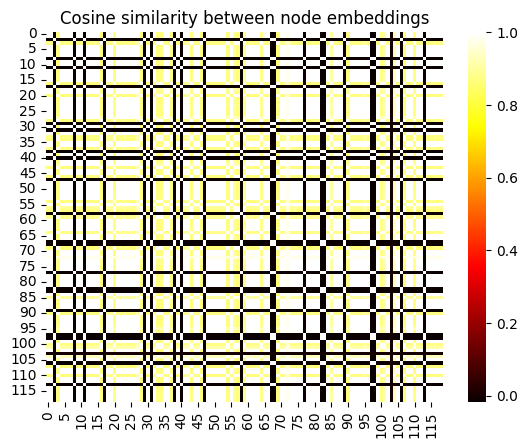

In [37]:
gnn = GNN(node_features=34, edge_features=1, hidden_channels=128, heads=4)

gnn.eval()

with torch.no_grad():
    data = graph_list[0]
    node_embeddings = gnn(data.x, data.edge_index, data.edge_attr, data.batch)
    cos_sim_matrix = torch.nn.functional.cosine_similarity(
        node_embeddings.unsqueeze(1),
        node_embeddings.unsqueeze(0),
        dim=-1
    )

print(cos_sim_matrix.mean(), cos_sim_matrix.std())
sns.heatmap(cos_sim_matrix.cpu().numpy(), cmap="hot")
plt.title("Cosine similarity between node embeddings")
plt.show()

In [40]:
graph_list[0].x

tensor([[ 0.4787,  0.0278,  0.7396,  ...,  0.1509,  0.6326, -1.2034],
        [ 0.7012, -0.5595, -0.2367,  ..., -0.3911, -1.0139,  0.2297],
        [-0.6346, -0.1518,  0.1215,  ..., -1.0562, -0.2497,  0.8286],
        ...,
        [-0.2329, -0.6818, -0.9272,  ...,  1.6072,  0.3218, -1.3520],
        [ 0.4645,  0.3493, -0.5274,  ...,  0.9442, -0.1168, -1.2497],
        [ 0.1861,  0.1096, -0.6330,  ..., -0.1086, -1.2249,  1.8277]])

In [26]:
route_times = []
for route_id, route in grouped:
    t = calculate_time(route_id, route.sort_values(by="order")["stop_id"].tolist())
    route_times.append(t)

np.mean(route_times).item()

9998.183292122923

In [72]:
for route_id, route in grouped:
    max_order = route["order"].max()
    for i, stop in enumerate(route.stop_id):
        order = route[route["stop_id"] == stop]["order"]
        order = order.values[0]
        d = times[route_id][stop]
        sorted_d = dict(sorted(d.items(), key=lambda item: item[1]))
        top_d = dict(list(sorted_d.items())[1:31])
        connected_orders = []
        for s in top_d.keys():
            o = route[route["stop_id"] == s]["order"]
            o = o.values[0]
            connected_orders.append(o.item())
        if order != max_order and order + 1 not in connected_orders:
            print(f"{route_id} - Not connected")

RouteID_00930ddc-25f9-4371-a437-1e37c9d0a80d - Not connected
RouteID_024a44ee-5a90-48d3-8f80-d8e7b124971e - Not connected
RouteID_024a44ee-5a90-48d3-8f80-d8e7b124971e - Not connected
RouteID_024a44ee-5a90-48d3-8f80-d8e7b124971e - Not connected
RouteID_024a44ee-5a90-48d3-8f80-d8e7b124971e - Not connected
RouteID_024a44ee-5a90-48d3-8f80-d8e7b124971e - Not connected
RouteID_024a44ee-5a90-48d3-8f80-d8e7b124971e - Not connected
RouteID_025ecb40-3116-45af-b6a1-db5a5531fafc - Not connected
RouteID_025ecb40-3116-45af-b6a1-db5a5531fafc - Not connected
RouteID_025ecb40-3116-45af-b6a1-db5a5531fafc - Not connected
RouteID_025ecb40-3116-45af-b6a1-db5a5531fafc - Not connected
RouteID_025ecb40-3116-45af-b6a1-db5a5531fafc - Not connected
RouteID_025ecb40-3116-45af-b6a1-db5a5531fafc - Not connected
RouteID_025ecb40-3116-45af-b6a1-db5a5531fafc - Not connected
RouteID_03256465-637e-4330-a753-9e86d50e976e - Not connected
RouteID_03256465-637e-4330-a753-9e86d50e976e - Not connected
RouteID_03256465-637e-43

KeyboardInterrupt: 